<a href="https://colab.research.google.com/github/LucjanJanowski/Generalized-Score-Distribution/blob/master/Generalized_Score_Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 Krzystzof Rusek,

AGH University of Science and Technology
Licensed under the MIT License (the \"License\");

In [0]:
#@title Licensed under the MIT License (the "License"); { display-mode:"form" }
# MIT License

# Copyright (c) 2018 Krzystzof Rusek and Lucjan Janowski

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/LucjanJanowski/Generalized-Score-Distribution/blob/master/Generalized_Score_Distribution.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/LucjanJanowski/Generalized-Score-Distribution/blob/master/Generalized_Score_Distribution.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Generalized Score Distribution

###### By Bogdan Ćmiel

Generalized Score Distributon (GSD) describes a class of two parameters distributions definded on discete support $\{1, 2, \cdots, M\}$ with no more than one change in the probability monotonicity. It means that for increasing index of the probability we can have:
* not increasing probabilities 
* not increasing to the index $k$ and than not decreasing
* not decreasing to the index $k$ and than not increasing 
* not decreasing probabilities

The above equations define GSD. 

Let us denote 
$$V_{\mathrm{min}}(\psi)=(\lceil\psi\rceil-\psi)(\psi-\lfloor\psi\rfloor),$$
$$V_{\mathrm{max}}(\psi)=(\psi-1)(M-\psi),$$
$$C(\psi)=\frac{M-2}{M-1}\ \frac{V_{\mathrm{max}}(\psi)}{V_{\mathrm{max}}(\psi)-V_{\mathrm{min}}(\psi)}.$$
Let
\begin{equation} 
	\begin{split}
		P_{F_\rho} & (\epsilon=k-\psi)=  
		 \frac{\rho-C(\psi)}{1-C(\psi)}[1-|k-\psi|]_{+} + \frac{1-\rho}{1-C(\psi)} 
		 \binom{M-1}{k-1}\left(\frac{\psi-1}{M-1}\right)^{k-1}\left(\frac{M-\psi}{M-1}\right)^{M-k},
	\end{split}
\end{equation}
where $\rho\in[C(\psi),1]$, $k=1,...,M$ and
\begin{equation}
	\begin{split}
	P_{G_{\rho}}& (\epsilon=k-\psi)	= \binom{M-1}{k-1}\\
	& \frac{\mathcal{B}\left(\frac{(\psi-1)\rho}{(M-1)(C(\psi)-\rho)}+k-1,\frac{(M-\psi)\rho}{(M-1)(C(\psi)-\rho)}+M-k\right)}{\mathcal{B}\left(\frac{(\psi-1)\rho}{(M-1)(C(\psi)-\rho)},\frac{(M-\psi)\rho}{(M-1)(C(\psi)-\rho)}\right)}, 
	\end{split}
\end{equation}
where $\rho\in(0,C(\psi))$, $k=1,...,M$.

If we denote by $H_{\rho}$ the distribution function of the noise then we will assume that

$$ H_{\rho}=G_\rho\ I(\rho<C(\psi)) + F_\rho\ I(\rho\geq C(\psi))$$

where $\rho\in(0,1]$ is a confidence parameter (see Remark ).



### Remark

The variance of the noise is equal to
$$\mathbb{V}_{H_{\rho}}(\epsilon)=\rho V_{\mathrm{min}}(\psi)+(1-\rho)V_{\mathrm{max}}(\psi).$$ 

Since the variance of the noise is a decreasing function of $\rho\in(0,1]$ then this parameter has an interpretation as a confidence parameter. 


From this moment we will assume the following
 
$$U=\psi+\epsilon,$$ 
where $\psi\in[1,M]$ is an unknown parameter, $\epsilon$ are independent random variables with distribution functions $H_{\rho}$, where $\rho\in(0,1]$ is an unknown parameter.





# Implementation


In [0]:
#@title Imports

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%config InlineBackend.figure_format = 'retina'

In [0]:
#@title Functions { run: "auto", vertical-output: true, display-mode: "form" }
#@markdown Definition of `log_prob` and `sample` functions

def log_newton(n,k):
    '''
    Logarithm of Binomial symbol - made to be numerically stable 
    '''
    return tf.math.lgamma(n+1) -\
          tf.math.lgamma(k+1) -\
          tf.math.lgamma(n-k+1)

def log_beta(x,y):
    return tf.math.lgamma(x) + tf.math.lgamma(y) - tf.math.lgamma(x+y) 

def log_prob(psi, rho, u, M, dtype=tf.float64):
    """
     log of Generalized Score Distribution
    Args:
        psi - psi parameters 
        rho - $rho in (0,1)$ parameters
        u - the value for which we are looking for the probability 1, 2, 3, 4,...M
    Returns
        lprob - log of the given probability
    """
    
    c1 = tf.constant(1.0, dtype=dtype)
    c2 = tf.constant(2.0, dtype=dtype)

  
    Vmin = (tf.math.ceil(psi)-psi)*(psi-tf.math.floor(psi))
    Vmax = (psi-c1)*(M-psi)
    C = (M-c2)/(M-c1)*Vmax/(Vmax - Vmin)
    
    log_beta_bin = log_newton(M-c1,u-c1) + \
        log_beta(rho*(psi-c1)/( (M-c1) *(C-rho))+u -c1, (M-psi)*rho/( (M-c1) *(C-rho)) + M -u) - \
        log_beta(rho*(psi-c1)/( (M-c1) *(C-rho)), (M-psi)*rho/( (M-c1) *(C-rho)))
    
    log_binomial =  log_newton(M-c1,u-c1) + \
        (u-c1)*(tf.math.log(psi-c1) - tf.math.log(M-c1) ) + \
        (M -u)*(tf.math.log(M-psi) - tf.math.log(M-c1) )
    
    dist_binomial = tf.exp(log_newton(M-c1,u-c1))*tf.pow(psi-c1,u-c1)*tf.pow(M-psi,M-u)/tf.pow(M-c1,M-c1)
    dist_min = tf.nn.relu(c1 - tf.abs(u-psi))
    
    ratio = (rho -C)/(c1-rho)*dist_min/dist_binomial
    
    logmix = log_binomial + tf.math.log1p(-rho) - tf.math.log1p(-C) + \
        tf.math.log1p(ratio)
    
    condition = tf.broadcast_to(rho,shape=u.shape) < C
    
    lprob = tf.where(condition,log_beta_bin, logmix)
    return lprob

def convert_and_brodcast(n, shape, dtype):
    '''Broadcast with type convertion
    Args:
        n (Tensor)
        shape (tensor_shape)
        
    Returns:
        Converted and broadcasted n
    '''
    tn = tf.convert_to_tensor(n,dtype=dtype)
    brodcasted = tf.broadcast_to(tn,shape)
    return brodcasted

def sample(psi,rho,M,num_samples=1, dtype=tf.float64):
    '''
    Sample the Generalized Score Distribution. 
    Args:
        psi - psi parameters 
        rho - rho parameters
        num_samples - number of samples for specific psi and rho pair
    Returns:
        tensor with 3 dimensions if num_samples > 1, we should use more than one psi and rho
    '''

    support=tf.linspace(1.,M,tf.cast(M,tf.int32))
    support = tf.cast(support, dtype)

    lprobs = log_prob(psi,rho,support,M)
    lprobs = tf.expand_dims(lprobs, axis=0)
    samples = 1+tf.random.categorical(lprobs, num_samples=num_samples)
    return samples


# Fit

* Estimate parameters for your own data 
* Test estimation accuracy 
* Plot the probability mass function

***Double click the form title to check the implementation details***

In [0]:
#@title User data {vertical-output: true, display-mode: "form" }

max_score=5 #@param {type:"integer"}
max_step=5000 #@param {type:"integer"}
grad_tol=1e-8 #@param {type:"number"}
#@markdown Enter coma separated scores
scores='5,5,5,4,3,3' #@param {type:"string"}


scores = [int(i) for i in scores.split(',')]


g=tf.Graph()

with g.as_default():

    samples = tf.convert_to_tensor(scores)
    u = tf.cast(samples, tf.float64)
    M=tf.convert_to_tensor(max_score,dtype=tf.float64)

    varrho = tf.Variable(tf.random_normal([],dtype=tf.float64,stddev=1.1))
    varpsi = tf.Variable(tf.random_normal([],dtype=tf.float64,stddev=0.1))

    bottom = tf.constant(1.0, dtype=tf.float64)
    top = tf.convert_to_tensor(M-1, dtype=tf.float64)


    rho = tf.nn.sigmoid(varrho) # [0,1]
    psi = bottom + top * tf.nn.sigmoid(varpsi) # [1,M]


    loglik = log_prob(psi,rho,u,M)
    loss = -tf.reduce_mean(loglik)
    optimizer = tf.train.RMSPropOptimizer(learning_rate=0.01)

    v = [varpsi, varrho]
    grad = tf.gradients(loss,v)
    train_op = optimizer.apply_gradients(zip(grad,v))


with tf.Session(graph=g) as ses:
    ses.run(tf.global_variables_initializer())
    for i in range(max_step):
        _,l,pygrad,psihat,rhohat = ses.run([train_op,loss,grad,psi,rho])
        if max(map(np.linalg.norm, pygrad)) < grad_tol:
            break
        if i % 100 ==0:
          print('#',end='')
    psi_hat, rho_hat = ses.run([psi,rho])

print('')
print('Ψ={0:.3f}, ρ={1:.3f}'.format( psi_hat, rho_hat))

##################################################
Ψ=4.176, ρ=0.709


In [0]:
#@title  Fitting from random sample { vertical-output: true, display-mode: "form" }

max_score=8 #@param {type:"integer"}
max_step=5000 #@param {type:"integer"}
grad_tol=1e-8 #@param {type:"number"}

true_psi=5.3 #@param {type:"number"}

true_rho=0.5 #@param {type:"number"}

n_samples=80 #@param {type:"integer"}

g=tf.Graph()

with g.as_default():

    samples= sample(np.float64(true_psi),np.float64(true_rho),np.float64(max_score),n_samples)


    u = tf.cast(samples, tf.float64)
    M=tf.convert_to_tensor(max_score,dtype=tf.float64)

    varrho = tf.Variable(tf.random_normal([],dtype=tf.float64,stddev=1.1))
    varpsi = tf.Variable(tf.random_normal([],dtype=tf.float64,stddev=0.1))

    c1 = tf.constant(1.0, dtype=tf.float64)
    top = tf.convert_to_tensor(M-1, dtype=tf.float64)


    rho = tf.nn.sigmoid(varrho) # [0,1]
    psi = c1 + top * tf.nn.sigmoid(varpsi) # [1,M]


    ll = log_prob(psi,rho,u,M)
    loss = -tf.reduce_mean(ll)
    optimizer = tf.train.RMSPropOptimizer(learning_rate=0.01)

    v = [varpsi, varrho]
    grad = tf.gradients(loss,v)
    train_op = optimizer.apply_gradients(zip(grad,v))


with tf.Session(graph=g) as ses:
    ses.run(tf.global_variables_initializer())
    for i in range(max_step):
        _,l,pygrad,psihat,rhohat = ses.run([train_op,loss,grad,psi,rho])
        if max(map(np.linalg.norm, pygrad)) < grad_tol:
            break
        if i % 100 ==0:
          print('#',end='')
    psi_hat, rho_hat = ses.run([psi,rho])

print('\nΨ={0:.3f}, ρ={1:.3f}'.format( psi_hat, rho_hat))

##################################################
Ψ=5.292, ρ=0.503


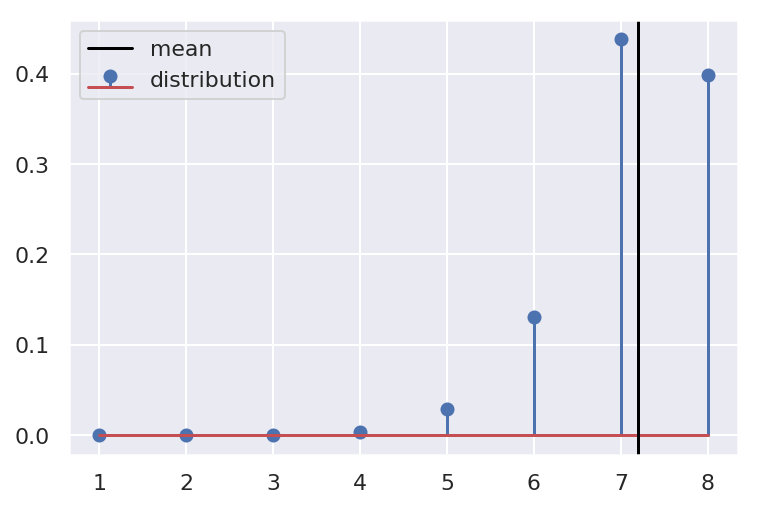

In [0]:
#@title Distribution { run: "auto", vertical-output: true, display-mode: "form" }

max_score=8 #@param {type:"integer"}
psi=7.2 #@param {type:"number", min:1.0}
rho = 0.9 #@param {type:"slider", min:0.01, max:1, step:0.01}



g=tf.Graph()

with g.as_default():

    support=tf.linspace(1.,max_score,max_score)
    support = tf.cast(support, tf.float64)

    lprobs = log_prob(np.float64(psi),
                      np.float64(rho),
                      support,
                      np.float64(max_score))

    probs = tf.exp(lprobs)

    


with tf.Session(graph=g) as ses:
    pyprobs,pysupport=ses.run([probs,support])
    #print(pyprobs);


ax=plt.subplot();

ax.stem(pysupport, pyprobs);
ax.axvline(psi, color='black');

ax.legend(['mean','distribution']);